# LSST CCOB ghost analysis

Develop the ghost images analysis

## TODO
- design a real image analysis to get a list of ghost spots
- update distance between 2 ghost spots to consider flux and size

## Notes
- for each optical element: 3 rotations, 3 positions
- L1, L2, L3, Filter, Detector, Beam: 6 x 6 = 36 parameters


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import timeit
import copy
import concurrent.futures 
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import batoid
import ghosts.plotter as plotter
import ghosts.simulator as simulator
import ghosts.tweak_optics as tweak_optics

from ghosts.analysis import compute_ghost_separations
from ghosts.analysis import match_ghosts, compute_reduced_distance, compute_2d_reduced_distance, find_nearest_ghost
from ghosts.analysis import make_data_frame

from ghosts.beam_configs import BEAM_CONFIG_1, BEAM_CONFIG_2, FAST_BEAM_CONFIG_1



In [3]:
from ghosts.constants import *
print(f'LSST Camera has {LSST_CAMERA_PIXEL_DENSITY_MM2:.0f} pixels per mm^2')

LSST Camera has 36000 pixels per mm^2


In [4]:
# CCOB like geometry, i.e. lenses + filters
telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r.yaml")

In [5]:
# test list of optics
assert tweak_optics.get_list_of_optics(telescope)==['L1', 'L2', 'Filter', 'L3', 'Detector'], 'Not a CCOB optical setup'

# Make refractive interfaces partially reflective
# Call on current telescope
tweak_optics.make_optics_reflective(telescope)


0.02

Direct path is number 28
  central impact point is (0.099469, -0.000010)
  transmission is 0.8337

Maximum expected flux is 0.8337
Maximum bin content is 660.3192


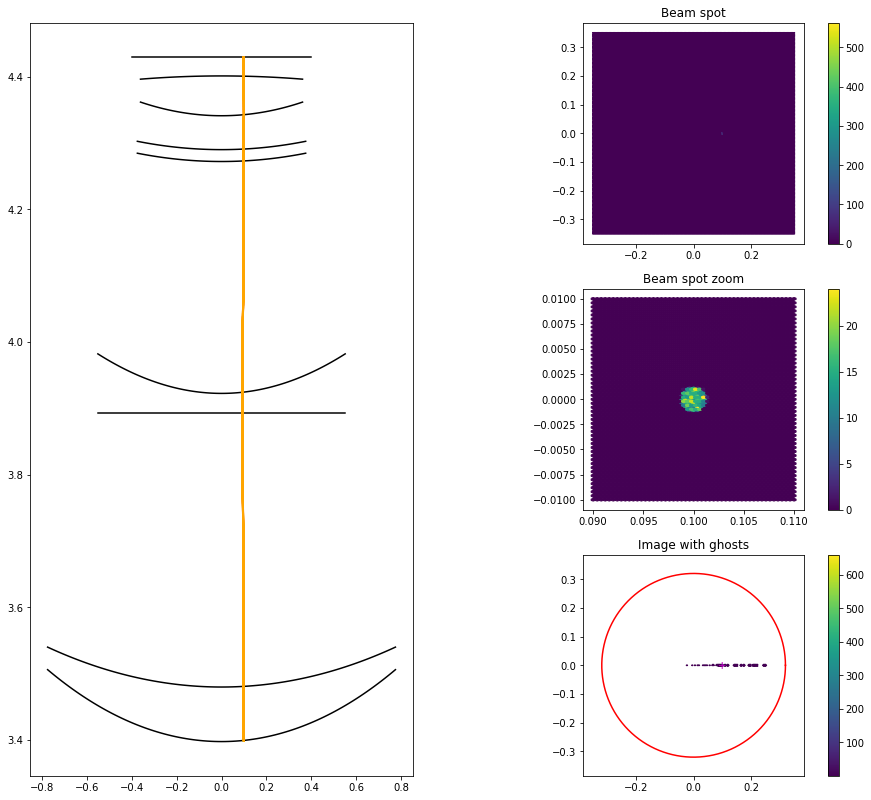

0

In [6]:
# Run simulation with standard beam config
traceFull, rForward, rReverse, rays = simulator.run_simulation(telescope, beam_config=BEAM_CONFIG_1)
simulation = [traceFull, rForward, rReverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)


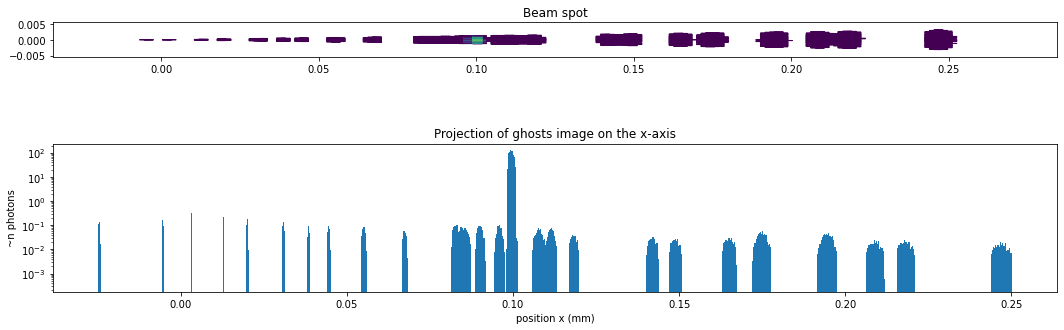

0

In [7]:
# Zoom on ghosts
plotter.plot_zoom_on_ghosts(rForward)

Ghosts map for 100 nW beam at 500 nm with a diameter of 2.5 mm


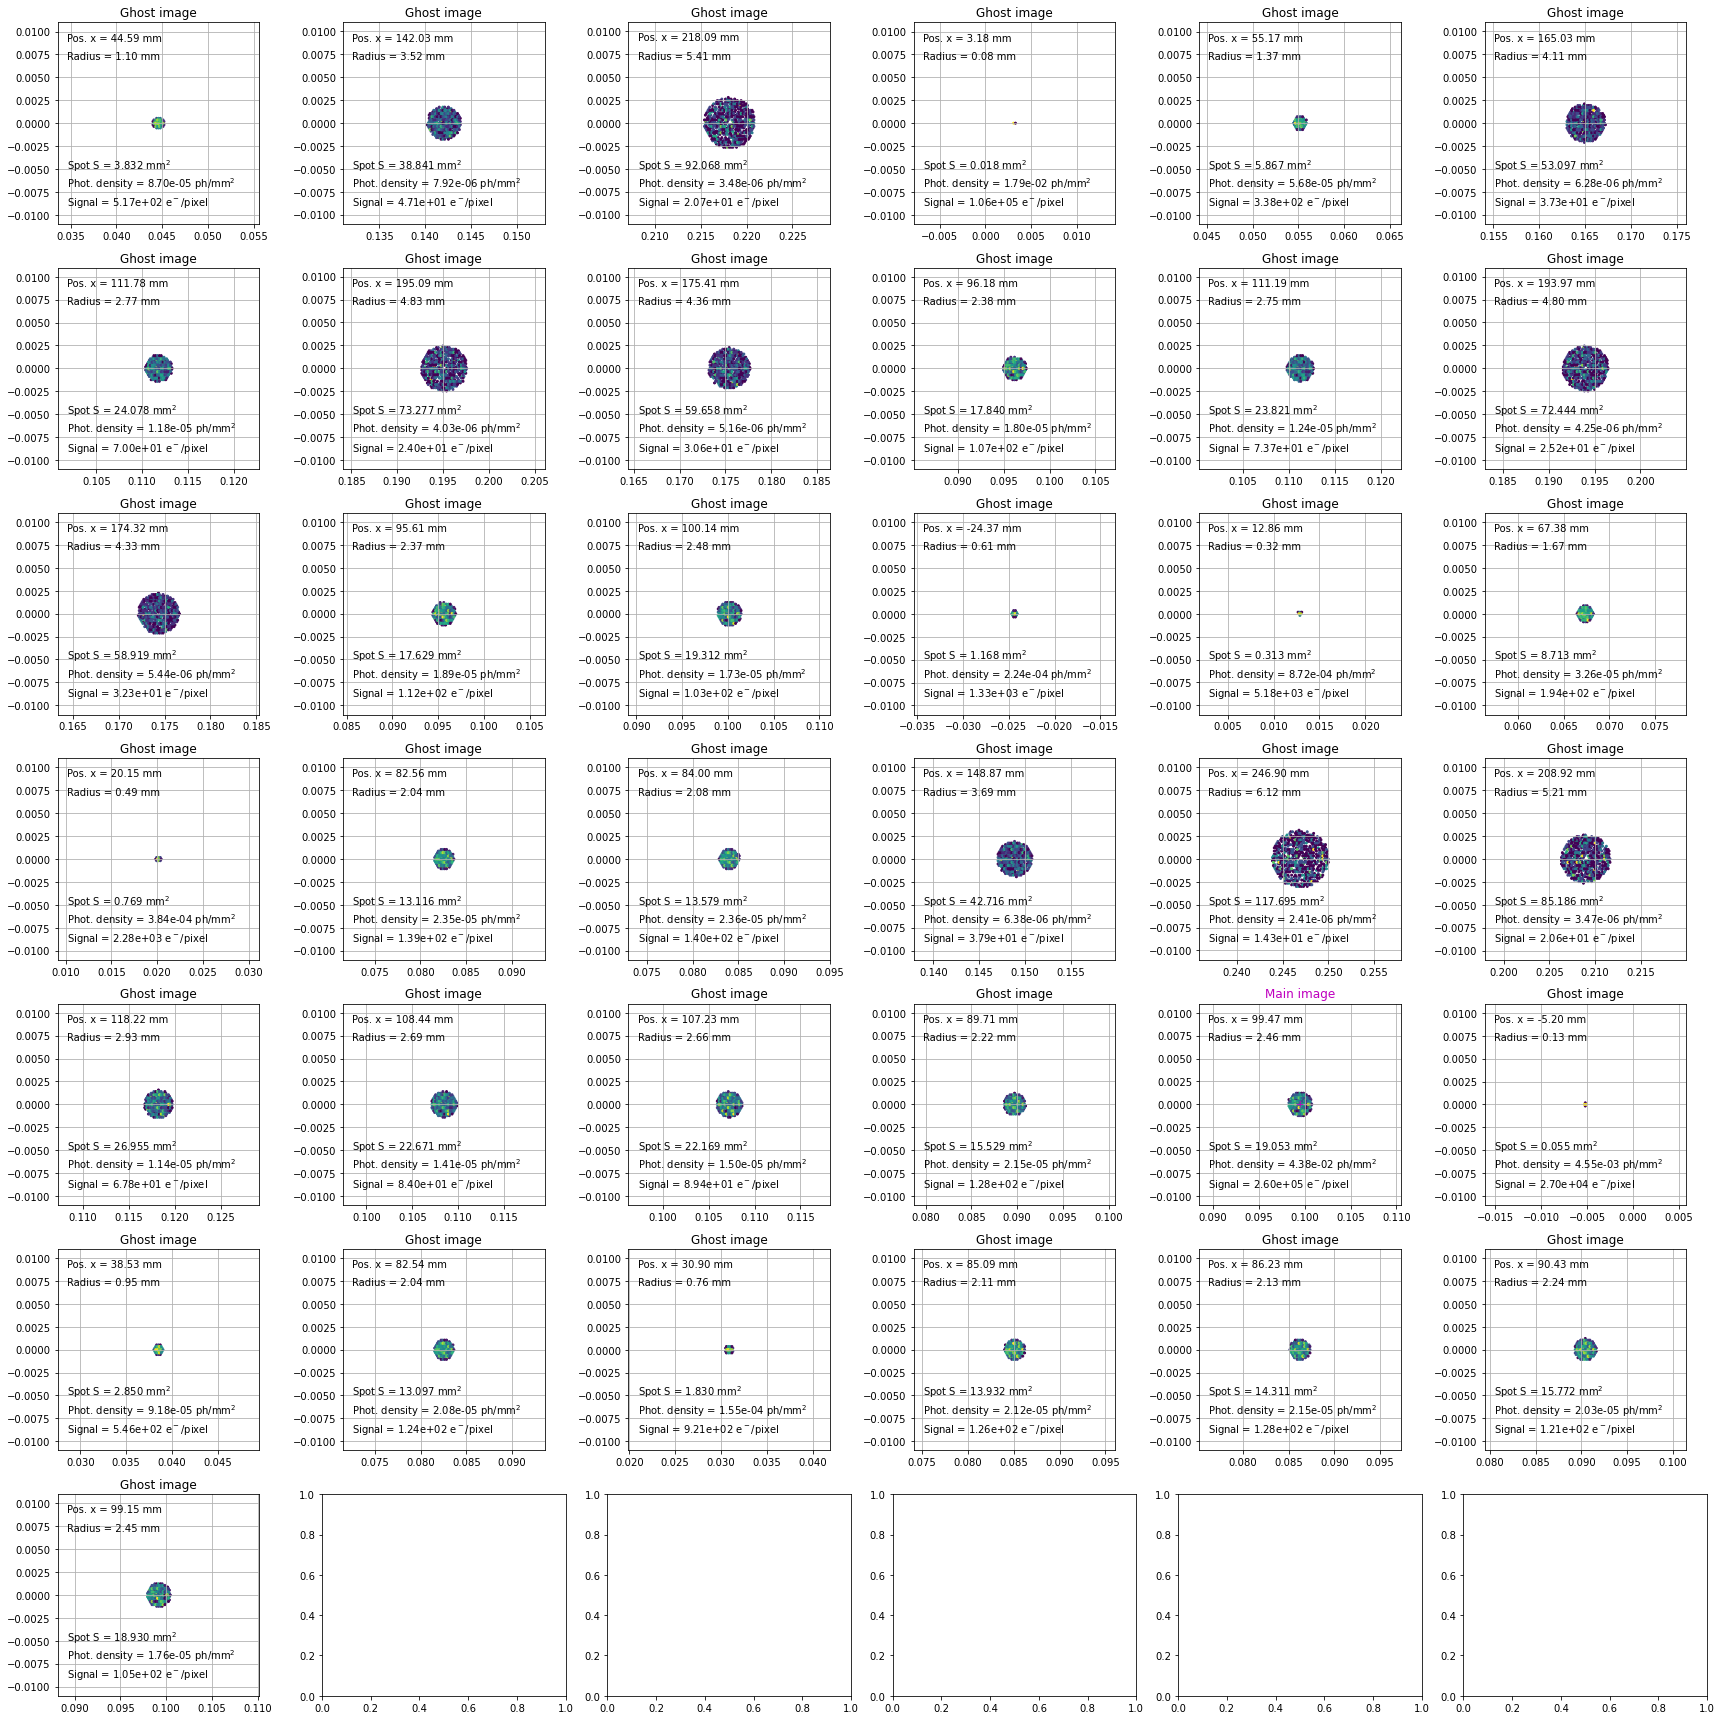

In [8]:
# make figure and fill with plots
plt.rcParams["figure.figsize"] = [24, 24]
spots_data = plotter.plot_ghosts_map(rForward)

In [9]:
data_frame_1 = make_data_frame(spots_data, BEAM_CONFIG_1)
data_frame_1.sort_values(by=['name'])

,config,n_photons,beam_x,beam_y,beam_width,beam_theta,beam_phi,index,name,pos_x,std_x,pos_y,std_y,width_x,width_y,radius,radius_err,surface,pixel_signal
33,1,1000,0.1,0,0.00125,0.0,0.0,33,"(Detector, Filter_entrance)",0.085085,0.000535,-8.421877e-06,0.000535,0.002092,0.002120,0.002106,1.415212e-05,13.932413,126.018556
34,1,1000,0.1,0,0.00125,0.0,0.0,34,"(Detector, Filter_exit)",0.086233,0.000542,-8.535460e-06,0.000542,0.002120,0.002149,0.002134,1.430303e-05,14.311290,127.740872
29,1,1000,0.1,0,0.00125,0.0,0.0,29,"(Detector, L1_entrance)",-0.005196,0.000035,5.142737e-07,0.000035,0.000136,0.000129,0.000133,3.156114e-06,0.055264,27028.915940
30,1,1000,0.1,0,0.00125,0.0,0.0,30,"(Detector, L1_exit)",0.038534,0.000242,-3.814165e-06,0.000242,0.000945,0.000960,0.000953,7.598442e-06,2.850490,545.629389
31,1,1000,0.1,0,0.00125,0.0,0.0,31,"(Detector, L2_entrance)",0.082544,0.000518,-8.170336e-06,0.000518,0.002027,0.002057,0.002042,1.496027e-05,13.096730,123.652314
32,1,1000,0.1,0,0.00125,0.0,0.0,32,"(Detector, L2_exit)",0.030903,0.000194,-3.058827e-06,0.000194,0.000757,0.000770,0.000763,6.709126e-06,1.830323,921.266388
35,1,1000,0.1,0,0.00125,0.0,0.0,35,"(Detector, L3_entrance)",0.090434,0.000570,-8.951200e-06,0.000570,0.002228,0.002253,0.002241,1.268130e-05,15.772123,120.688635
36,1,1000,0.1,0,0.00125,0.0,0.0,36,"(Detector, L3_exit)",0.099151,0.000624,-9.814137e-06,0.000624,0.002439,0.002471,0.002455,1.584743e-05,18.929611,104.703858
10,1,1000,0.1,0,0.00125,0.0,0.0,10,"(Filter_entrance, L1_entrance)",0.111189,0.000700,-1.100565e-05,0.000700,0.002737,0.002770,0.002754,1.682684e-05,23.821458,73.704241
11,1,1000,0.1,0,0.00125,0.0,0.0,11,"(Filter_entrance, L1_exit)",0.193973,0.001220,-1.919972e-05,0.001220,0.004771,0.004833,0.004802,3.113225e-05,72.444223,25.235093


Rotation around Y as Euler:
 [0. 1. 0.]
Rotation around Y as  matrix:
 [[ 0.9998477   0.          0.01745241]
 [ 0.          1.          0.        ]
 [-0.01745241  0.          0.9998477 ]]
L1 before rotation:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
L1 after rotation:
 [[ 0.9998477   0.          0.01745241]
 [ 0.          1.          0.        ]
 [-0.01745241  0.          0.9998477 ]]
Ghosts map for 100 nW beam at 500 nm with a diameter of 2.5 mm


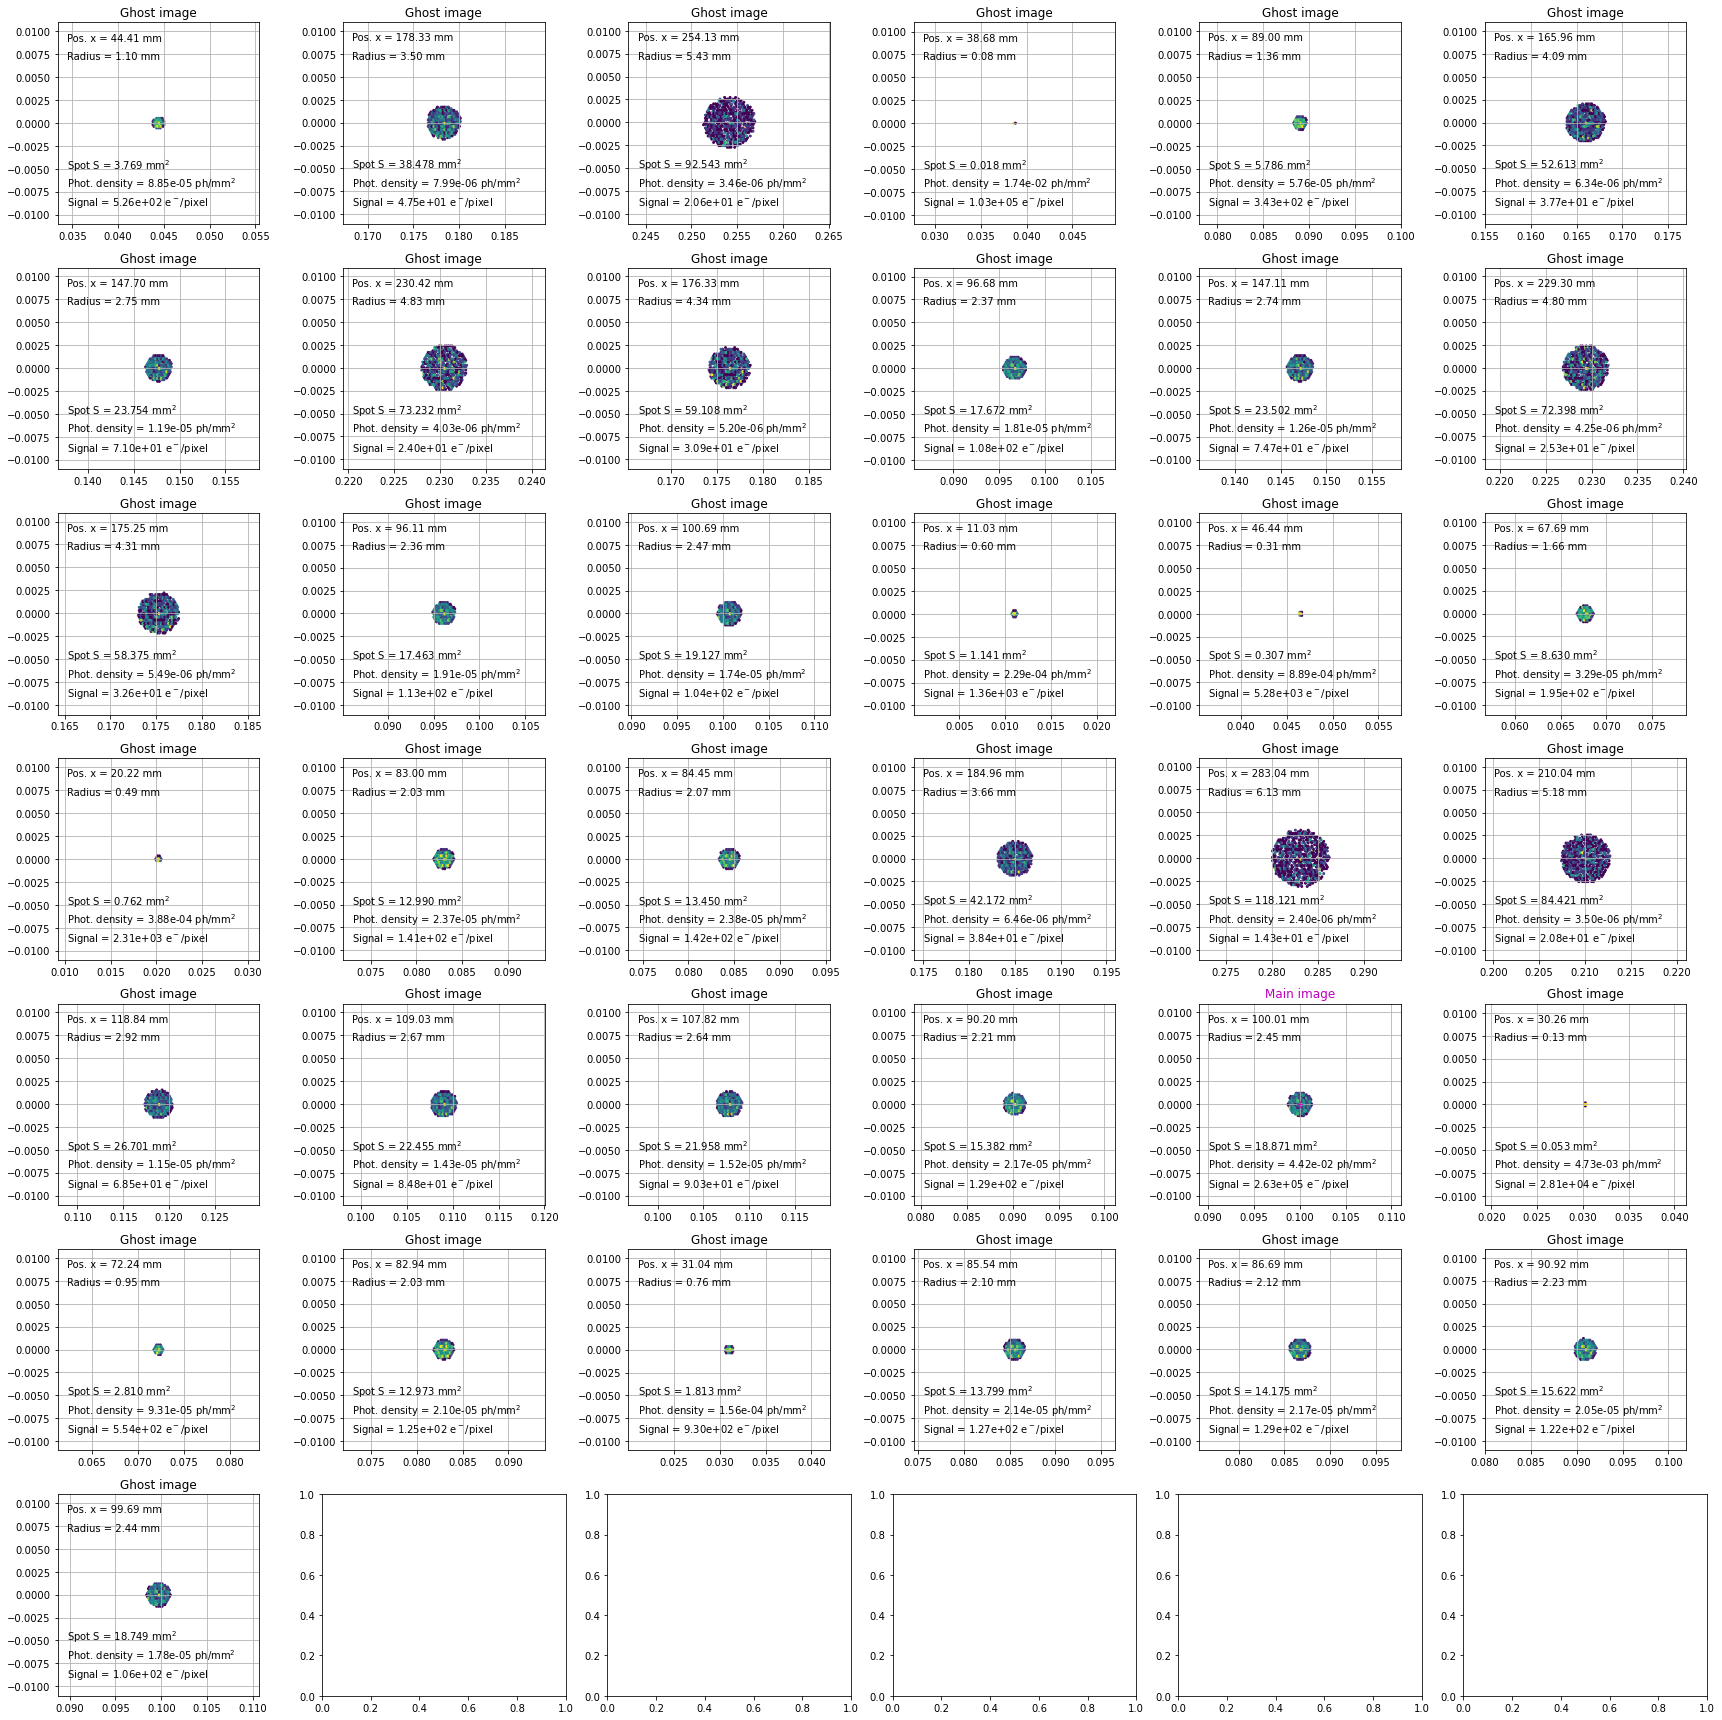

In [10]:
# Run another simulation with rotated L1
rotated_telescope = tweak_optics.rotate_optic(telescope, 'L1', axis='y', angle=1, verbose=True)
tweak_optics.make_optics_reflective(rotated_telescope)

traceFull_2, rForward_2, rReverse_2, rays_2 = simulator.run_simulation(rotated_telescope,
                                                                       beam_config=BEAM_CONFIG_1)
plt.rcParams["figure.figsize"] = [24, 24]
spots_data_2 = plotter.plot_ghosts_map(rForward_2)


In [11]:
data_frame_2 = make_data_frame(spots_data_2, BEAM_CONFIG_1)
data_frame_2.sort_values(by=['name'])

,config,n_photons,beam_x,beam_y,beam_width,beam_theta,beam_phi,index,name,pos_x,std_x,pos_y,std_y,width_x,width_y,radius,radius_err,surface,pixel_signal
33,1,1000,0.1,0,0.00125,0.0,0.0,33,"(Detector, Filter_entrance)",0.085538,0.000527,-0.000035,0.000527,0.002115,0.002076,0.002096,1.942178e-05,13.799398,127.233272
34,1,1000,0.1,0,0.00125,0.0,0.0,34,"(Detector, Filter_exit)",0.086693,0.000534,-0.000035,0.000534,0.002144,0.002104,0.002124,1.972224e-05,14.174614,128.972590
29,1,1000,0.1,0,0.00125,0.0,0.0,29,"(Detector, L1_entrance)",0.030260,0.000033,0.000002,0.000033,0.000134,0.000126,0.000130,3.873887e-06,0.053192,28081.767402
30,1,1000,0.1,0,0.00125,0.0,0.0,30,"(Detector, L1_exit)",0.072243,0.000237,-0.000016,0.000237,0.000953,0.000939,0.000946,6.966321e-06,2.809890,553.513168
31,1,1000,0.1,0,0.00125,0.0,0.0,31,"(Detector, L2_entrance)",0.082942,0.000510,-0.000034,0.000510,0.002050,0.002014,0.002032,1.767187e-05,12.973451,124.827309
32,1,1000,0.1,0,0.00125,0.0,0.0,32,"(Detector, L2_exit)",0.031035,0.000191,-0.000013,0.000191,0.000765,0.000754,0.000760,5.516843e-06,1.813212,929.960332
35,1,1000,0.1,0,0.00125,0.0,0.0,35,"(Detector, L3_entrance)",0.090922,0.000561,-0.000037,0.000561,0.002253,0.002207,0.002230,2.303920e-05,15.622457,121.844849
36,1,1000,0.1,0,0.00125,0.0,0.0,36,"(Detector, L3_exit)",0.099690,0.000614,-0.000040,0.000614,0.002466,0.002420,0.002443,2.326763e-05,18.748550,105.715016
10,1,1000,0.1,0,0.00125,0.0,0.0,10,"(Filter_entrance, L1_entrance)",0.147107,0.000687,-0.000045,0.000687,0.002759,0.002712,0.002735,2.343354e-05,23.501853,74.706556
11,1,1000,0.1,0,0.00125,0.0,0.0,11,"(Filter_entrance, L1_exit)",0.229298,0.001208,-0.000079,0.001208,0.004854,0.004747,0.004801,5.307933e-05,72.397685,25.251315


In [12]:
match_1_2 = match_ghosts(data_frame_1, data_frame_2)
match_1_2

hello [0.00017677344179851807, 0.13374520652645364, 0.20954119060783777, 0.005909922699271224, 0.04441391694347829, 0.12136892081849157, 0.10311586021590109, 0.18583478323685299, 0.13174669975609457, 0.052092258252226915, 0.10252025627578357, 0.18471208581351978, 0.13065885836431582, 0.05152100476193564, 0.05610257764988318, 0.03355316074190386, 0.0018517797119305477, 0.023108288123117337, 0.02436635778117572, 0.03841404017934184, 0.03986779913713094, 0.1403756031157457, 0.23845606887937096, 0.1654503178946886, 0.07425470866298745, 0.06444344841362651, 0.06322959158705073, 0.04561260156094299, 0.055425557121024184, 0.014326683379955088, 0.027656969739404173, 0.038355916960898226, 0.01355110828464345, 0.04095205696976495, 0.04210677340613285, 0.04633597271698107, 0.05510360730554163]
hello [0.09762355959720653, 0.03629790290918245, 0.11209387924246257, 0.10335724208694544, 0.05303340680424891, 0.02392164428029831, 0.005668619941032817, 0.08838747295217399, 0.0342994113368885, 0.04535507

hello [0.06878287979260268, 0.20270432161647414, 0.2785003053306462, 0.06304919504565303, 0.11337303282214654, 0.1903280341150341, 0.17207497551280823, 0.25479389803004204, 0.20070581310231916, 0.12105137060547862, 0.17147937157757906, 0.2536712006106213, 0.19961797170546955, 0.12048011709648658, 0.1250616901275234, 0.035405959918406775, 0.07081089676187532, 0.09206739829205293, 0.04459276059552741, 0.10737315192654433, 0.10882691096963563, 0.20933471816458732, 0.30741518352394265, 0.23440943136540712, 0.14321382151578566, 0.1334025610920282, 0.13218870423968235, 0.11457171367628714, 0.12438466957969145, 0.05463243492032568, 0.09661608595438177, 0.10731502869643715, 0.055408013032959245, 0.10991116886113261, 0.11106588535753455, 0.11529508486231499, 0.12406271975457937]
hello [0.031545902853901346, 0.16546734395855683, 0.24126332791204347, 0.02581221656044927, 0.07613605466521649, 0.15309105720762958, 0.1348379977209428, 0.2175569205601742, 0.16346883620068764, 0.08381439365798618, 0.1

hello [0.00587619830649546, 0.13979762724175432, 0.21559361131015037, 0.0001425212599493754, 0.05046633767005005, 0.12742134129075278, 0.10916828093696258, 0.1918872039396787, 0.137799120247292, 0.05814467835302381, 0.10857267699700769, 0.19076450651640253, 0.13671127885364964, 0.057573424854775485, 0.06215499780205445, 0.02750074016036046, 0.007904200608681725, 0.02916070716560875, 0.01831393706479924, 0.04446646001149444, 0.04592021900827684, 0.146428023829569, 0.24450848958041027, 0.1715027384307961, 0.08030712896775569, 0.07049586864828186, 0.06928201181125038, 0.051665021558272406, 0.06147797726525259, 0.00827426306691126, 0.03370939048126785, 0.044408336789698466, 0.007498690007520587, 0.04700447686774794, 0.04815919333108672, 0.05238839272753696, 0.06115602744583602]
hello [0.038133786057833796, 0.09578766407923477, 0.1715836479287767, 0.04386746708136071, 0.006456384411025083, 0.08341138081190048, 0.06515831806377355, 0.14787724062466936, 0.09378915938990902, 0.0141347360281273

,ghost_1,ghost_2_2d,distance_2d,distance_2d_err,ghost_2_3d,distance_3d,distance_3d_err
0,0,0,0.000177,0.000556,0,0.000177,0.000556
1,1,10,0.005073,0.001594,10,0.005133,0.001594
2,2,23,0.008055,0.002692,23,0.008058,0.002693
3,3,15,0.007855,0.000217,15,0.007872,0.000217
4,4,16,0.008735,0.000503,16,0.008798,0.000504
5,5,5,0.000927,0.002086,5,0.000927,0.002087
6,6,25,0.002755,0.001376,25,0.002757,0.001377
7,7,21,0.010123,0.002169,21,0.010190,0.002170
8,8,12,0.000169,0.002199,12,0.000175,0.002199
9,9,13,0.000078,0.001199,13,0.000082,0.001199


In [13]:
compute_reduced_distance(match_1_2)

0.0012122224622432849

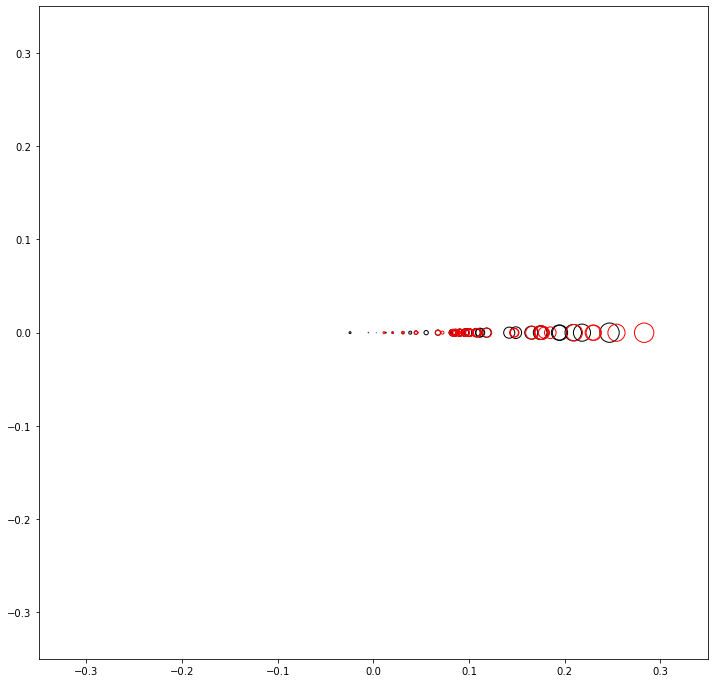

In [14]:
fig, ax = plotter.plot_spots([data_frame_1, data_frame_2])

In [15]:
# See what happens with a random telescope
data_frame_r, ghost_separations_r = simulator.full_random_telescope_sim(telescope,\
                                    max_angle=1, max_shift=0.001, beam_config=BEAM_CONFIG_1)


distance 3d = 0.00308
distance 2d = 0.00147


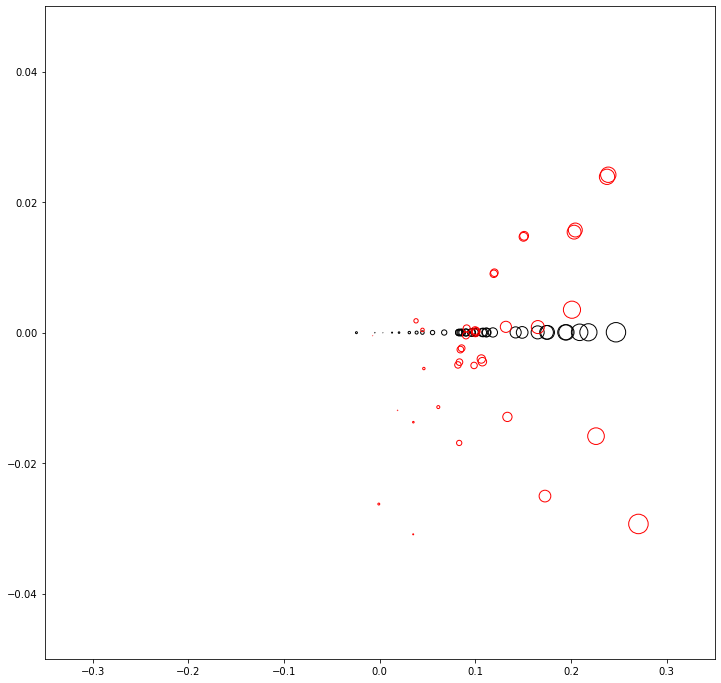

In [27]:
match_1_r = match_ghosts(data_frame_1, data_frame_r)
dist_1_r = compute_reduced_distance(match_1_r)
print(f'distance 3d = {dist_1_r:.5f}')
dist_1_r_2d = compute_2d_reduced_distance(match_1_r)
print(f'distance 2d = {dist_1_r_2d:.5f}')
fig, ax = plotter.plot_spots([data_frame_1, data_frame_r], range_y=(-0.05, 0.05))


In [36]:
# See what happens with a random telescope
data_frame_r2, ghost_separations_r2 = simulator.full_random_telescope_sim(telescope,\
                                    max_angle=1, max_shift=0.001, beam_config=BEAM_CONFIG_1)


distance = 0.00350


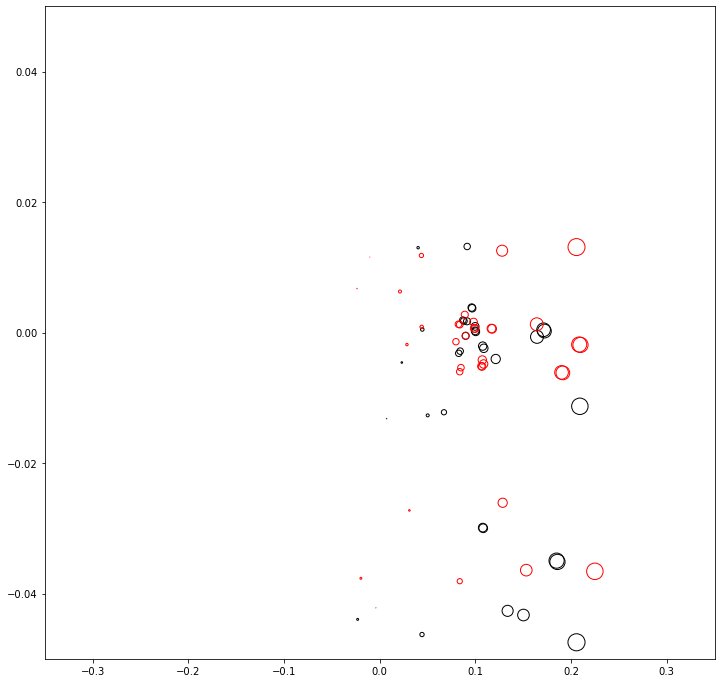

In [40]:
match_r_r2 = match_ghosts(data_frame_r, data_frame_r2)
dist_r_r2 = compute_reduced_distance(match_r_r2)
print(f'distance = {dist_r_r2:.5f}')
fig, ax = plotter.plot_spots([data_frame_r, data_frame_r2], range_y=(-0.05, 0.05))


In [41]:
match_r_r2

,ghost_1,ghost_2_2d,distance_2d,distance_2d_err,ghost_2_3d,distance_3d,distance_3d_err
0,0,0,0.000757,0.000557,0,0.000783,0.000557
1,1,24,0.017356,0.001636,21,0.026505,0.001822
2,2,23,0.022079,0.002702,23,0.029437,0.002702
3,3,15,0.016185,0.000221,16,0.041137,0.000113
4,4,16,0.018842,0.000502,17,0.049849,0.000767
5,5,5,0.001939,0.002087,5,0.002343,0.002087
6,6,24,0.020714,0.001439,24,0.026037,0.001440
7,7,12,0.029364,0.002325,11,0.040566,0.002433
8,8,5,0.008045,0.002149,12,0.019194,0.002206
9,9,36,0.002549,0.001221,36,0.007078,0.001221


In [24]:
distances_2d = list()
distances_3d = list()
for i in range(10):
    df_i, gs_i = simulator.full_random_telescope_sim(telescope,\
                         max_angle=1, max_shift=0.001, beam_config=FAST_BEAM_CONFIG_1)
    match_i = match_ghosts(data_frame_1, df_i)
    dist_i = compute_reduced_distance(match_i)
    distances_3d.append(dist_i)
    
    match_i2 = match_ghosts(data_frame_1, df_i)
    dist_i2 = compute_2d_reduced_distance(match_i2)
    distances_2d.append(dist_i2)


hello [0.0008047485209975245, 0.11010789274601154, 0.19001698207671258, 0.05867961227169946, 0.0542248087644991, 0.11898138828548764, 0.03651100079410966, 0.11535876051054397, 0.10968376479776389, 0.035016256265333376, 0.03601849044473386, 0.11432497230381514, 0.10868691964717085, 0.03452099779691709, 0.05427877866049059, 0.06702870938520392, 0.02985364730394335, 0.036959037957374666, 0.02018523402448946, 0.04349841995908478, 0.04433544353868389, 0.11165248280781914, 0.22155381841654329, 0.17542571881279748, 0.07812035519000074, 0.06821796700226389, 0.06643129434790987, 0.04517590731398544, 0.053650954869364824, 0.08109295347597206, 0.037157345543374215, 0.025567850930639454, 0.03203608791205402, 0.03998308471432008, 0.0410805373646493, 0.04328146523259455, 0.05259755008922196]
hello [0.09819011140196808, 0.04622908547379833, 0.09972306385061643, 0.14205900148486336, 0.09056941947427495, 0.021559339948427375, 0.06880049118970093, 0.02545923837901741, 0.0158156766188694, 0.0653306683351

hello [0.20305564653358937, 0.11227631607902859, 0.054836179840578626, 0.24373784341824467, 0.18730097779797705, 0.08334528586342631, 0.17207136786378435, 0.0907782226641643, 0.09374779540339452, 0.16957994063768445, 0.17262685049673365, 0.09178408708514044, 0.09475362525137833, 0.17011397337476994, 0.14803434144599667, 0.26567840261723, 0.21443945706199372, 0.16583242183455935, 0.22104144510458418, 0.15883867169178797, 0.1579970413133506, 0.09707030269681649, 0.033788267938303446, 0.027386664370486077, 0.12475866275911983, 0.13411049176832227, 0.13589392372175946, 0.15713777579719213, 0.1486621544186228, 0.2824363843114161, 0.23710756290450027, 0.18134751624082926, 0.231653656098195, 0.16233276808357647, 0.16123484671054159, 0.1590358563513831, 0.14971617444563765]
hello [0.16508005836546621, 0.07921258412269834, 0.054581982339428126, 0.2065485603756682, 0.15102209949152887, 0.04537631964689769, 0.13438830731703366, 0.05432282830674428, 0.05618142490258966, 0.13171456008212698, 0.1349

hello [0.15124147072453398, 0.06844328392578425, 0.06071321659244161, 0.19307262205957332, 0.13802890731082207, 0.031544134621023824, 0.12070191323912251, 0.04171803246147974, 0.042672451560162424, 0.1179337551700315, 0.12125278921225599, 0.04261672657966348, 0.04366039124415722, 0.11846728651275998, 0.09622008572606877, 0.21414997738876698, 0.163210140686458, 0.1140576123984118, 0.16927008217163536, 0.10702691004615021, 0.10618485548613403, 0.04903223467695667, 0.07498451149455297, 0.025327976163838497, 0.07309889832038213, 0.08229949271610774, 0.08408211642265075, 0.10532358154254652, 0.09684789713525277, 0.2307089128580661, 0.18541076379622665, 0.129744800476917, 0.17995716407048168, 0.1105187649808513, 0.10942080813999475, 0.10722203451481241, 0.09790200181548014]
hello [0.13156169226333622, 0.05552274498843656, 0.07315062266221896, 0.17400663132321748, 0.11987768964107746, 0.011899228759103611, 0.10130981007703906, 0.026047608723212344, 0.024114080708849798, 0.09836409886589231, 0

hello [0.00531921058723641, 0.1156306088722168, 0.1958514131473688, 0.055046912493615076, 0.056920140291472514, 0.12503353877676124, 0.04181239141470201, 0.1213274214456525, 0.11570924152605389, 0.040787586281664595, 0.041300820191364475, 0.12029256779657976, 0.11471164945514867, 0.04028313531538728, 0.06033119883027973, 0.06145521431319824, 0.02834339176265595, 0.04295632889076348, 0.014800944647073414, 0.04954854117340751, 0.050386047042985, 0.11755188847526896, 0.22755553533553674, 0.18147590629776458, 0.08414773646940094, 0.0742695588377163, 0.07248303619259247, 0.051228275617678044, 0.05970337583309885, 0.07514982395418617, 0.03164182246566943, 0.03083080912610044, 0.026696993514208907, 0.046035216256437896, 0.04713272552599528, 0.04933347996463942, 0.05864992406821451]
hello [0.03870109258810854, 0.07730257425245243, 0.1538111622953453, 0.08777678769131651, 0.05226932011918917, 0.08102646114307666, 0.01998768762694755, 0.0782205747547284, 0.07199833513270901, 0.012367363005885977

hello [0.20160004708797014, 0.11469701460195694, 0.042974376162970916, 0.25187837566075366, 0.20149485338110243, 0.08199296192861398, 0.18041215977000052, 0.11375850783378293, 0.10150800622957964, 0.1703303110984782, 0.18074129629521543, 0.11431572999432107, 0.10205821274032142, 0.17063217549324633, 0.14665330194395648, 0.28366637190683813, 0.25160860927866696, 0.1868060232679577, 0.2301489331720075, 0.16218663295012875, 0.16087926465499935, 0.10841816989552708, 0.014629987065495243, 0.04457883453845884, 0.13092198446076528, 0.134982558931983, 0.13635391730111146, 0.15709631783633826, 0.1469822864900009, 0.2532695976162888, 0.21031844243398926, 0.16097889311969904, 0.21211987143999148, 0.15746286379976576, 0.15664615681532992, 0.15549884716035317, 0.14704729529953295]
hello [0.16362489890227788, 0.07766428910439814, 0.018864320373970137, 0.21403242103178646, 0.16368154004585295, 0.04403128872605186, 0.14320203635757434, 0.07821137543066338, 0.06377734520430141, 0.13239094060032675, 0.1

hello [0.05088688157844287, 0.04330559513835134, 0.11367585596235394, 0.1022418020579064, 0.05281042870369827, 0.06876202378194203, 0.04182691397272978, 0.0533888490028067, 0.050453461186821404, 0.020559606344550837, 0.042014114262863625, 0.052858288445297726, 0.049886038011520646, 0.020833410872272647, 0.004175280449948773, 0.13298565022848602, 0.10094588978023479, 0.038026296595031206, 0.07977202312597098, 0.011900120895701971, 0.010549560705445092, 0.04288199328554404, 0.13623045892877594, 0.10832410625935784, 0.02156671397519231, 0.01597590850006795, 0.014560658670605953, 0.0063838947791196934, 0.0038408873537073584, 0.10434310743486833, 0.0628541197211121, 0.010835362071137923, 0.06144021325686522, 0.006745621014684454, 0.005931061498891254, 0.005099217112900453, 0.003913723849949739]
hello [0.0658943544913402, 0.031012413037004628, 0.09890566191685443, 0.11701880657557044, 0.06721194854533552, 0.05375801939529523, 0.05272274437770305, 0.042641738311573814, 0.035794382384797846, 0

hello [0.014428597963268818, 0.1053072252550453, 0.17837787671965002, 0.04003942454083178, 0.022636383556710712, 0.13402983975372237, 0.05009948162199909, 0.11215944471063197, 0.11526081091287296, 0.04626055073027117, 0.04980931801279198, 0.11155229198352334, 0.1146950376345249, 0.04595327826656852, 0.06935268924492392, 0.06777872306701209, 0.03584167745777104, 0.032528748672864594, 0.016686630451021648, 0.053944623867327256, 0.05522227558702114, 0.10790749789396785, 0.20150326872808008, 0.1733642763299693, 0.08568888616017947, 0.08108114820322752, 0.0796935410661268, 0.05890147790806648, 0.0690225721226387, 0.04382795082585302, 0.024565902410205512, 0.05517581542190019, 0.004694681429883077, 0.05853420584890577, 0.05935117113732057, 0.06053526541175262, 0.06896844447186024]
hello [0.039794672470858695, 0.053294465271885215, 0.12463035111587359, 0.09136772713739577, 0.042436856806663065, 0.07985390441786519, 0.03574363394733812, 0.062472772678782554, 0.061397984153954165, 0.01065105683

hello [0.20197857158324525, 0.13978980395518617, 0.07044200573662554, 0.27555948119463747, 0.2241834408690587, 0.0828371412461907, 0.17254525883524074, 0.09329702737579094, 0.0809795024704094, 0.1557495594673717, 0.1730594706426948, 0.09424272429711311, 0.0818633077567916, 0.15622578594225855, 0.14701138134524022, 0.29046040520849875, 0.25075561175159616, 0.17233732293142953, 0.22036969458325725, 0.1623559709749524, 0.1611003223359437, 0.11952468645049588, 0.03535975599720064, 0.03141737247994183, 0.1228537271634665, 0.13645158055048484, 0.13783983951026998, 0.15728533586957635, 0.14757145341025046, 0.2758262420339303, 0.23105514138410688, 0.1619008834682976, 0.21291346969377278, 0.16071571131600873, 0.15967867681386103, 0.15697874935907966, 0.14802944268133056]
hello [0.16400292920422432, 0.10333589163578846, 0.04242997253289657, 0.23791391304312537, 0.1867842082765995, 0.044862778921275534, 0.13463561511654284, 0.05544543162058566, 0.04396483802536813, 0.11791006736914307, 0.13514999

hello [0.13048448925194706, 0.07247089591799884, 0.03749662216990667, 0.20478809771052334, 0.15400908618646847, 0.011352588660963354, 0.10121654675148975, 0.022388306810054184, 0.015726221213560064, 0.08461321464268137, 0.10173095952209818, 0.023320229993535613, 0.016160852329832255, 0.0850837400612942, 0.0755173001369771, 0.2193899436549617, 0.18000397124877365, 0.10084762035621468, 0.148877120526654, 0.09087843394429244, 0.08962034278118282, 0.05275105314804945, 0.06350817499686606, 0.040181505176773186, 0.051363211773339724, 0.06498222567669179, 0.06636524683335977, 0.08579143205084579, 0.07607737244647633, 0.20448972578489938, 0.15977025235869133, 0.09056942565660794, 0.14149242074758372, 0.08922273096289537, 0.088185552371342, 0.08548564357458309, 0.07653555308698108]
hello [0.05125909888325062, 0.03685735511725655, 0.09698544238231506, 0.12731039160619576, 0.07905846919945082, 0.06788569676214568, 0.023385475456789668, 0.05789534663546849, 0.07207885115555465, 0.01235541258483562

hello [0.014018162981906997, 0.08708109319809552, 0.1594697406394842, 0.06663647142014803, 0.03591480307389417, 0.13316201296748542, 0.0445991508944318, 0.12301772830907216, 0.13676622106048017, 0.061743260815054136, 0.04410554993654776, 0.12208024370007595, 0.13585278356544223, 0.061263144179008494, 0.06898532674292025, 0.0781400604147594, 0.044877997571897706, 0.04368993891071, 0.004525589852514769, 0.053725348389267874, 0.05496589214789051, 0.10365390154040313, 0.20216399297236912, 0.18464814703749804, 0.09314891739277026, 0.07960611699869716, 0.07820683890057614, 0.05871215792344355, 0.06842525562082347, 0.06143443246604334, 0.020702145103003246, 0.054911519845951676, 0.008481217103568799, 0.055286368085876475, 0.056322560592751154, 0.059022229585102115, 0.06796791750252938]
hello [0.040164537622405655, 0.0426060801530738, 0.10737115749581376, 0.1166481344184161, 0.06932561432018991, 0.0789800011292193, 0.013815408771540411, 0.06894293892674448, 0.08300804631095707, 0.0131722102955

hello [0.20283603750563864, 0.13706752027328276, 0.0660862638668749, 0.2756260378516955, 0.22736573540886157, 0.0829513041489137, 0.13496834475830619, 0.08496493132047975, 0.06133710245453973, 0.13111977144803466, 0.13548597907192161, 0.08491530088513866, 0.06188405003153861, 0.13174206296843152, 0.14689277300035203, 0.24463503278473223, 0.19540656705260842, 0.14150230127914679, 0.19698551132378284, 0.16170454689061506, 0.1605235861493855, 0.07204437069594126, 0.038191138558216604, 0.0034361231147184697, 0.09967279415137097, 0.13700256428909566, 0.13847228023249458, 0.15655846088611866, 0.14775770990697373, 0.25932242830237023, 0.21525599130873244, 0.153636921647678, 0.20524882204340178, 0.16435778579686883, 0.1630070595178206, 0.15819216318224058, 0.148767150029586]
hello [0.16486039803961686, 0.09909789099260642, 0.028831137137962044, 0.23765254359682597, 0.18942464574879148, 0.044976323900525826, 0.10415761151591159, 0.08280543237558109, 0.04666489121967962, 0.09520027168999472, 0.1

hello [0.05211660130780591, 0.013824116253317162, 0.08558979359371183, 0.12492278245399617, 0.0769844001238287, 0.06776992048941445, 0.07725343977269455, 0.1509099717855231, 0.12027380362823728, 0.043830766528835004, 0.07671170321251637, 0.14947558924127016, 0.1187965629894132, 0.04322478763151047, 0.00396611737694844, 0.0939988218228222, 0.04485907265379647, 0.010372443927643655, 0.046268037243308045, 0.012935196387062864, 0.011598976412918733, 0.07915819149238384, 0.18882947217425594, 0.15160779176412045, 0.0510715667899166, 0.015252157379624277, 0.013610988264929375, 0.005839590045849841, 0.003046506352924367, 0.1107097400701492, 0.06836738123868805, 0.014674211295763526, 0.055782458818297014, 0.014000011334224153, 0.012616063724770471, 0.007665906333488515, 0.002295621387782736]
hello [0.06712598490355509, 0.002470179341322232, 0.07066889122365831, 0.1399289965037267, 0.09191047048175763, 0.052760797219756676, 0.07176991173917227, 0.1385202897124098, 0.10659713315262977, 0.03748329

hello [0.013160907050843636, 0.07897211119308986, 0.1506867400670203, 0.059678023866672224, 0.01427247971678666, 0.13304667030412562, 0.12150285430911795, 0.20883084691653125, 0.1822119709895152, 0.09698843326004009, 0.1207591712794949, 0.20735596402077008, 0.18073707885157278, 0.096230497906627, 0.06911519159188872, 0.029027199323623354, 0.02111928561350094, 0.07471176876343771, 0.019018181114195388, 0.054904360339869444, 0.055967134592577676, 0.14433136351624623, 0.254101416785938, 0.21687401167829887, 0.11633955687782907, 0.07939653764349466, 0.07784969042489764, 0.05943832511914509, 0.06824433634832931, 0.05039125627485566, 0.02702213115879224, 0.06469264277124231, 0.01770931557928566, 0.051777447895180385, 0.05310014547612008, 0.057840785875681346, 0.06724509138370961]
hello [0.04102205329236713, 0.024848919149757627, 0.0966365637383712, 0.11383111059925555, 0.06597573559228889, 0.07886434902987921, 0.08283562048061095, 0.16035608426781192, 0.13057158761835536, 0.05091428634824539

hello [0.20250079956638442, 0.08152475504610474, 0.04131825595545297, 0.2146392018042674, 0.1626949506162409, 0.08063951061298907, 0.14069459013881513, 0.06635250801196829, 0.09668216437626977, 0.16986455049601848, 0.14114848520716775, 0.0671845386233677, 0.09744122941817351, 0.17027678108545535, 0.14650483401783193, 0.2474820033221051, 0.20974300708772123, 0.17973488530891366, 0.2286816088475414, 0.16059351551338163, 0.1594297989378433, 0.0803217570442044, 0.04623019428346284, 0.03874208901924947, 0.13079914902960096, 0.13471337972404138, 0.13619958734170143, 0.15667950982155016, 0.14698035657427752, 0.23282277197581125, 0.19001346468256164, 0.16892154001015341, 0.220962914957463, 0.15891862729065795, 0.15797505693588296, 0.1563416954520444, 0.1474172725156826]
hello [0.16452519618214734, 0.05177213753815855, 0.06096681339688775, 0.17740957181014522, 0.1261361005164809, 0.042671572144187896, 0.1031792342410412, 0.030319901443484305, 0.05918578999100347, 0.13197367129968088, 0.10363271

hello [0.13100680943148446, 0.03970232211252169, 0.08880986228325531, 0.14487169695521773, 0.09479822711262237, 0.00921284912790261, 0.07047787717304456, 0.015528993202126307, 0.02721786049243938, 0.09858425647528327, 0.07092799406599688, 0.015309469318726053, 0.027866580264502047, 0.09899233391986308, 0.07501096838294065, 0.17708939681781438, 0.14002372595752516, 0.10824913281475336, 0.15718753200541422, 0.08911611212574942, 0.08795030753143626, 0.035482216879602055, 0.1061317061497353, 0.032797165123306986, 0.05930697382605519, 0.06324140097169495, 0.06472364157487667, 0.08518626369621839, 0.07548665447000007, 0.16220097490546986, 0.11988306756467097, 0.09744811926851414, 0.14948366193631984, 0.08743069846422562, 0.08648647996765581, 0.08484764352415784, 0.07592333708221223]
hello [0.05178181856430687, 0.08887523006764861, 0.16332879358118257, 0.07165245393780914, 0.039420551137619435, 0.07009858312126308, 0.02183196765629813, 0.08700823215307286, 0.05607387512136012, 0.0213377805178

hello [0.013498640050901931, 0.1501364138704962, 0.22713471051651715, 0.03878437503435779, 0.06973211015507784, 0.1353710023968396, 0.07880006615177768, 0.15179615947595468, 0.12065375802410008, 0.04749092310492682, 0.07837845356466931, 0.15098693290126564, 0.11986435446418435, 0.04706986100439611, 0.06949257696812794, 0.04654333565310357, 0.03913064428127432, 0.03633687109163981, 0.012685159550266896, 0.05548417655690537, 0.056635398478878336, 0.14824266633292651, 0.2468253910232667, 0.17727984273580352, 0.08520156456583333, 0.08133525427091287, 0.07984154083314354, 0.05932082377334997, 0.06901760420871138, 0.03370053903789708, 0.04071036398425466, 0.04720419525873416, 0.006169122919803493, 0.05710654756765177, 0.058046435341778106, 0.059655140770078975, 0.06857992323064695]
hello [0.040687437417579055, 0.09892553579687419, 0.17409636194148395, 0.06257803041499772, 0.03892527200546988, 0.08119178606095524, 0.029152278677639927, 0.09797382763130054, 0.0669545870732295, 0.01265353726436

hello [0.1649140605377917, 0.07958861223855283, 0.05531151672090099, 0.2057841695501622, 0.15934332138561436, 0.044086867095798836, 0.07328423834358652, 0.012231010188656957, 0.03359180965065791, 0.10566424639690895, 0.07391157278756265, 0.011159547295501282, 0.03422496055391482, 0.10622409837392705, 0.10843146134761758, 0.2122752858527406, 0.17646842986022257, 0.13984726998613548, 0.1841870349792178, 0.1264113210235414, 0.12493051553736254, 0.03787676105788582, 0.06295712992874479, 0.036740592601318595, 0.0873017812781087, 0.10037299859143659, 0.10156567529099891, 0.1189623804083118, 0.1091349032647536, 0.1965840128558374, 0.15416935272143306, 0.1210499048204427, 0.17222726535663305, 0.12412475542589141, 0.12292687841488183, 0.11838945597464919, 0.10951972086321361]
hello [0.07421508759744688, 0.059007531891908764, 0.11625109386242241, 0.1200559939023476, 0.07989581400911444, 0.04664077308083643, 0.020770674303682804, 0.10266701599994478, 0.07156060720965311, 0.02337426297070452, 0.02

hello [0.06838255137558523, 0.17962395730389827, 0.2514342911994357, 0.06134684763043586, 0.09883321590118675, 0.18922787998766716, 0.16103904089716345, 0.24524421857636464, 0.2113421583871049, 0.1308406874121802, 0.16043008585406454, 0.24408745388564518, 0.21018959370551774, 0.13023876474001414, 0.12486717619072242, 0.021561622342728945, 0.06050368143154489, 0.10542577780979102, 0.058600537697871956, 0.10696882847390009, 0.1084310611860821, 0.19556649770594664, 0.294719304151667, 0.2446515026414513, 0.1526584636859657, 0.13296139953994718, 0.13175704663207805, 0.11433483828161986, 0.12416523779482892, 0.04836853003771909, 0.08603291469102717, 0.11306719986004618, 0.06199671060664736, 0.10922070958826799, 0.11041294876268005, 0.11494680971943043, 0.12379311000463894]
hello [0.03114559695042649, 0.14430969404738658, 0.2152122019169812, 0.051197611840286046, 0.07043326697926595, 0.15199174218866776, 0.12389834959463177, 0.20800986876134916, 0.17440122999749025, 0.09417128511629916, 0.123

hello [0.00025270402420705544, 0.11101383865181412, 0.18196372605307423, 0.02944518156312204, 0.017409342879350614, 0.12157430943452911, 0.1467835945505334, 0.24528344041044572, 0.17842461771169285, 0.08653219421690449, 0.1459199215085268, 0.24361343905824612, 0.17675618714566593, 0.08567584193184781, 0.0567260853115391, 0.05281466408252387, 0.03879176780297283, 0.035337818448806596, 0.02331741884217306, 0.03432902907896015, 0.03610322807100991, 0.13958937919632755, 0.23376207672866697, 0.17338862004697264, 0.08270827207593132, 0.05987081400157991, 0.059050146543444176, 0.04590803373875434, 0.05570915446204826, 0.03053561012543609, 0.03876570902834585, 0.05101615003547649, 0.011192218923827883, 0.037514260325321444, 0.038959999935425954, 0.04703464227403382, 0.05552787975446638]
hello [0.09719690359393206, 0.013886028686486314, 0.08453467899858418, 0.12666049715285296, 0.08006748556514245, 0.024133417149357496, 0.05021110479365095, 0.1487289005525554, 0.08224609008388557, 0.01563479882

hello [0.1640870474937717, 0.053462150003271945, 0.0177734205010224, 0.1935265099259307, 0.14695523433776364, 0.04276927290795266, 0.02133082473166255, 0.08365859589486735, 0.023403000328869304, 0.07915163292677133, 0.02193409817373787, 0.08196626695348362, 0.022132975526043427, 0.07994707899087694, 0.10761140517217482, 0.20563322181043683, 0.17289409236842115, 0.1354077273716561, 0.1819086912225376, 0.1305986809250676, 0.12871639019363496, 0.04628301497259084, 0.07626013552727427, 0.019450374724743674, 0.0845234687000302, 0.1048355693107951, 0.10560017779040475, 0.11843508675228971, 0.10863000401900023, 0.17990845506262934, 0.13800605883303993, 0.11495350215760988, 0.16767784772846858, 0.12711610643782378, 0.12562186779683304, 0.11730290080762433, 0.10880984850042669]
hello [0.07338806864753511, 0.037463922699198, 0.10833601703819093, 0.10286782317114992, 0.05626087781785842, 0.04793827137402819, 0.07359359229059102, 0.17222679638200064, 0.10553024060082529, 0.01615360962200377, 0.072

hello [0.13056860773704593, 0.020100264152360346, 0.0511852254623931, 0.16001764093796894, 0.1134376416530663, 0.009267211345015425, 0.019281552218448766, 0.11600664444180564, 0.05044116435544871, 0.04614697055633783, 0.018466021631259263, 0.11431488392882104, 0.04875867602420105, 0.046906362819802545, 0.07409296830881522, 0.1727559021725605, 0.14041922929814296, 0.10230065670861893, 0.1485516339474364, 0.09712243569776213, 0.095234988233649, 0.03598027024227092, 0.1067239085349077, 0.045256063784941444, 0.051937009137629685, 0.07138007430739277, 0.07213385439204908, 0.08491726953619769, 0.07511181936003113, 0.14686988418413707, 0.10527466938941514, 0.08164001887100658, 0.1342461173351218, 0.09362151339602118, 0.09212444462050999, 0.08378446895500068, 0.07529144726425581]
hello [0.05134321883959191, 0.059459273642926046, 0.1303763685570811, 0.08084642087361614, 0.03422085416570847, 0.06998185298991164, 0.09543184869363154, 0.19405134415999659, 0.12726251242927497, 0.035875440630287296,

hello [0.03770713786372941, 0.07307967345887184, 0.144010358879329, 0.06723253635528847, 0.020592932692355057, 0.08361748709360947, 0.10898179260122295, 0.2075744656054304, 0.1407539218866238, 0.04907449394173156, 0.10811405812236323, 0.2058993454145732, 0.13907763244847274, 0.04820920737806742, 0.01876857261414858, 0.0843489695072311, 0.0571357655608125, 0.01995522132996179, 0.05713256756015301, 0.006978167530927594, 0.005661589062535465, 0.10335539556316735, 0.1963910006202358, 0.1356835845815663, 0.04597499982077701, 0.022316496123599525, 0.021450803366622574, 0.007969919453921075, 0.017754001345567098, 0.058274417010661016, 0.027525370048513305, 0.016018263426649304, 0.04234702522460406, 0.004168458717324311, 0.0038953663358126645, 0.009077326884894807, 0.01757070973064765]
hello [0.013934054657075211, 0.1246924911405628, 0.19564620876382105, 0.01602148600507686, 0.03108226406690502, 0.13525773966678342, 0.16042907754063201, 0.2588952389521863, 0.19203250601560484, 0.10012795814572

hello [0.16491861620678477, 0.0562706136401804, 0.02429364334691007, 0.19412881362470727, 0.1379589484287962, 0.04446299799051575, 0.10128038887419337, 0.015923150011829444, 0.039829711137301826, 0.11881926648010462, 0.10190838001833342, 0.01705011871106161, 0.04095965828199066, 0.11942241652511383, 0.10911308843637713, 0.2578407660794835, 0.22507900444491788, 0.1632975814661085, 0.2061568425735746, 0.12968678492832933, 0.12798061231927435, 0.0860650041831025, 0.026322473782826598, 0.02527804144994302, 0.10803332388086642, 0.10343529264412048, 0.1043841122999623, 0.12012650054104948, 0.10983227611970507, 0.22477037819633058, 0.18044444092135006, 0.13692427199472962, 0.18757296031871112, 0.12497775456331896, 0.12377404498458217, 0.11844421493393283, 0.10987002312777559]
hello [0.07421982187696904, 0.03443400769866388, 0.11494831105186502, 0.10343577387665966, 0.047260352726106354, 0.04624917441216162, 0.010584827135032629, 0.07521951338144278, 0.05118877489713623, 0.02814335416243564, 0

hello [0.05217511378932996, 0.05647749558495382, 0.1369912558552343, 0.08139436621763879, 0.02521601480831484, 0.06829194076849804, 0.011467373210008642, 0.09724695665969188, 0.07319155001223303, 0.00620680262639097, 0.01084143894040988, 0.09606903292423365, 0.07204137705836385, 0.0067870274700159924, 0.0036337526457951427, 0.14565419467435395, 0.11341021442084916, 0.05140751651636035, 0.09366504163372028, 0.017090841230381446, 0.015374948520974208, 0.0359904107767569, 0.12527822752819978, 0.09164457813207295, 0.011404628702768522, 0.009654823005419606, 0.008669135254609987, 0.007382898322526036, 0.002912350086398533, 0.11219695487433606, 0.06797413484633237, 0.024291418613178694, 0.07487188764998744, 0.01224909214223911, 0.011044334661598213, 0.005746904883750267, 0.002895285129470377]
hello [0.06718440121233606, 0.04146887090008842, 0.1219830836974754, 0.09640124567110693, 0.04022499918549469, 0.05328377745149802, 0.0035569356445174223, 0.0822484002192106, 0.058207343229929924, 0.021

hello [0.013104540639106172, 0.12175357337647404, 0.20226526561187091, 0.016182490938353368, 0.04006300616482881, 0.133567022308498, 0.0767415946935584, 0.162500319202215, 0.1384227214511707, 0.05922330474208492, 0.07611402260769537, 0.16132354191504528, 0.13727431186639738, 0.058618312212210755, 0.06890821910746081, 0.08140652254071234, 0.050967142438240014, 0.018821108173876593, 0.029429103054282525, 0.04841641758662298, 0.050107133143127966, 0.0968366303612687, 0.18973976905051643, 0.1565638623777139, 0.07119423190070547, 0.07465524043636433, 0.07369341388446897, 0.05789460405675154, 0.0681888345975859, 0.047390220933342254, 0.00802937184055038, 0.04120000019343184, 0.010067132311615162, 0.053048832040347424, 0.05425155049031871, 0.05958389994307823, 0.06815246932278027]
hello [0.0410806820255328, 0.06757170912564832, 0.14808507402835688, 0.07030235390167229, 0.014122318944786154, 0.07938589261052546, 0.022560202696133347, 0.1083354376370175, 0.08427325692018085, 0.00519269005585177

hello [0.05087786953521117, 0.03673027245995848, 0.10519429779401836, 0.10441301178120685, 0.061355257203449635, 0.06958479697114757, 0.0797456931087158, 0.17632029429867907, 0.12853433245231463, 0.037994175235805464, 0.07890969335732079, 0.17472250816673562, 0.12694558501153788, 0.03717996108403328, 0.00552237455930482, 0.14959381101255884, 0.1358784219024343, 0.06437377372464897, 0.0908821217479858, 0.024529806443583876, 0.02201550035762708, 0.07137698627136245, 0.138784453934941, 0.10695078213436993, 0.03996489932064215, 0.009807567329152844, 0.008912334562364736, 0.006645587579589755, 0.004574017890627338, 0.07908333320009715, 0.03914683049441887, 0.01578141636407008, 0.05061757202896244, 0.01378413097496206, 0.012323310242377436, 0.003083273672536156, 0.005271313037136251]
hello [0.05540971892843683, 0.032453109492350286, 0.10074106047356372, 0.10892189539480855, 0.06570408492529044, 0.06505306757240258, 0.07526892730169703, 0.1718381740092631, 0.12402378548030647, 0.0334933546354

hello [0.049931358268433174, 0.13619945492595234, 0.2051445282414672, 0.01116354870353633, 0.0457428210675767, 0.17039075687205119, 0.18004128912566716, 0.2764402598891247, 0.22908470093838187, 0.13863479497931716, 0.17921590535948426, 0.2748553596001256, 0.22750970414197025, 0.13783398769263783, 0.10632740296286537, 0.06949456542745053, 0.0716263828336322, 0.07053033945244495, 0.039715583860066836, 0.0787931353597455, 0.08107414246502226, 0.14962329181350983, 0.23050641963629173, 0.2024400718485692, 0.12144876995246905, 0.10472746856791716, 0.10440667103997496, 0.09426524255602846, 0.1053587591456726, 0.03441127859622537, 0.07126124222698393, 0.10614727500706136, 0.05473856176395811, 0.0876243573481864, 0.08905524452013436, 0.09817730916035382, 0.106060313678496]
hello [0.006206988430684681, 0.09269527288865581, 0.16165541159830288, 0.047998732966110555, 0.017937125066544525, 0.1266608146751024, 0.13644041579148142, 0.23293538645542144, 0.1854316517671194, 0.09493339589259343, 0.13561

hello [0.13067157764408366, 0.04630871588647572, 0.03040023501632564, 0.1839672387622229, 0.13963869201917006, 0.010230462349026373, 0.012088422535205723, 0.09807430693912678, 0.049688264315909086, 0.04223627537515204, 0.011967479977774318, 0.09646408922986828, 0.04807262177623478, 0.04300574136618434, 0.07427470222256677, 0.22512229345192292, 0.2083922886367144, 0.13378168897918233, 0.16721201215084758, 0.10283358733936282, 0.10038146137387063, 0.07627455930367195, 0.08282906518431828, 0.04964151548030769, 0.07481457925031067, 0.07682256992588071, 0.0769726452472616, 0.0863506562069986, 0.07524548794397236, 0.15709340442048292, 0.11461614022784983, 0.07706218881766068, 0.12895521067182356, 0.09313341042112572, 0.09168094059664912, 0.0824525849376531, 0.07454380155297836]
hello [0.05144667887563796, 0.03619002618036564, 0.10463498391519033, 0.10497883038930313, 0.06189965387331054, 0.069016000682947, 0.0791834525193105, 0.17575758583560352, 0.1279681133335221, 0.03742884793485609, 0.07

hello [0.07349128619278407, 0.016776850511380587, 0.0830579991877782, 0.1269280816062631, 0.08324998644887807, 0.046972422967692246, 0.057493307633776296, 0.1539841229882301, 0.10604543615933291, 0.015714618859030798, 0.05665341145742347, 0.15238241555268758, 0.10445099067689784, 0.014888792160507432, 0.017094822219807106, 0.17060467743492239, 0.155707391911793, 0.08215033444469301, 0.11202481894987498, 0.04620613063893318, 0.04370266262856993, 0.06329730096205138, 0.12022383540495095, 0.0871901564242219, 0.03791752480106787, 0.02117568847019442, 0.02104617858180863, 0.029184566143385434, 0.018069521131039223, 0.10090846194656301, 0.05939775963139237, 0.023841196730965224, 0.07249655219374872, 0.03607293610879078, 0.03460999455479253, 0.02530660735391622, 0.01736779637190854]
hello [0.06370896288587564, 0.02485548448201686, 0.09260559779986494, 0.11718366400260305, 0.0737253328934011, 0.05675414610650992, 0.06708978524920492, 0.16363713603573068, 0.11576790531629656, 0.0252797810759151

hello [0.0009379688556113917, 0.14208297896200625, 0.21941468043426837, 0.040855939412833275, 0.06522540227117542, 0.12156157378977785, 0.12141066021906079, 0.2150779029600031, 0.15244324150583297, 0.06843627307680528, 0.120635352619936, 0.21359330607500238, 0.15095556759094192, 0.06767271959980556, 0.05607092638958513, 0.06192389623325457, 0.04998340335296733, 0.018275595446175484, 0.0310736909139086, 0.03607578485085822, 0.03761979362028425, 0.13643734417756734, 0.23322055017087007, 0.1589479407879883, 0.06822549726112342, 0.06166745773284217, 0.06061739087616481, 0.04516482702521415, 0.05518189151187927, 0.03216392618667729, 0.027199238585349554, 0.033928011831530894, 0.02116923285756251, 0.03827375763460528, 0.03960953619713383, 0.046002424417689154, 0.054883125284529446]
hello [0.09813118221395484, 0.0566610871871997, 0.12564796499773453, 0.10950264215823453, 0.06501149149655838, 0.024134795934008173, 0.028882680235134316, 0.11954985073446124, 0.06335744079808327, 0.04695931513390

hello [0.05624216586405436, 0.09045041134360046, 0.1654358533357895, 0.0722943474748181, 0.043716882957494554, 0.06600912559721933, 0.06696979301838903, 0.16033256458499703, 0.09975568009889475, 0.030712585978125522, 0.06618609556661414, 0.1588375218281754, 0.09826972886312892, 0.03034617348803622, 0.0005357675006298913, 0.10934613433050426, 0.0816126566287329, 0.040322786670460554, 0.08652397554093856, 0.02156632285177521, 0.01975887533695714, 0.08570869552858998, 0.17945554257414242, 0.10354881534725122, 0.013184232747314848, 0.009165178787172363, 0.008047621243075148, 0.010410809164134668, 0.00040847521789089467, 0.08268068770067158, 0.04228988160767994, 0.02457238423114135, 0.07526325167864754, 0.0179139497639238, 0.01650970275302457, 0.009619999538344024, 0.0007602049024599469]
hello [0.06828040845089424, 0.2089898211969068, 0.28725338711825443, 0.07642184621149614, 0.12549624984244775, 0.19051885023896953, 0.1898859781888779, 0.28346938998097343, 0.2198151469562939, 0.13383788474

hello [0.04910522132539155, 0.19023708353455007, 0.26833125203381053, 0.06103880473802743, 0.1076944838535403, 0.1713428394524897, 0.17080507080111398, 0.2644212702205442, 0.20097210390551765, 0.11523518695548891, 0.17003547832485105, 0.26294395219178224, 0.19949349172573336, 0.1144645965567306, 0.10585357374878306, 0.042435424148328196, 0.06334609510596913, 0.066486278229658, 0.01914534724014282, 0.08541067852295803, 0.08704976598272264, 0.1842748101609098, 0.28198848559286877, 0.2086606662867821, 0.11795763444793027, 0.11126246942050254, 0.11024112187306083, 0.09494571419099665, 0.10496452225846752, 0.03286310077457056, 0.07102277914315465, 0.08297966206908491, 0.031905232526273995, 0.08794343040089289, 0.08930072651023432, 0.09577927537304576, 0.10466533697365704]
hello [0.005409171514006111, 0.14787981149035373, 0.22534153784643216, 0.04067627460859049, 0.0698749413287861, 0.12761375357552762, 0.12739972750570544, 0.22106638606742363, 0.15830164379640263, 0.07391804069307087, 0.126

hello [0.0522793468846255, 0.09398545964006115, 0.16925257274592664, 0.06905249549441966, 0.04328792855215526, 0.06997169380401043, 0.07079588922741789, 0.16421973273123405, 0.10341468339179848, 0.03171121328656414, 0.07001258040665674, 0.16272550219353143, 0.10192710069124476, 0.031263569454348474, 0.0044796446282006075, 0.10570113017759152, 0.07848083525910708, 0.03645953392016113, 0.08256372976050756, 0.01789682869835699, 0.01609498107588253, 0.0891369044855626, 0.18325542993085805, 0.10749528333239712, 0.01699984363577296, 0.012033830545963981, 0.010853071064261853, 0.006457149398298482, 0.003591669696596007, 0.07885286387930225, 0.038847905872751075, 0.02093736450052845, 0.07133005572640276, 0.01407278511182271, 0.012671758682193566, 0.005694856019189166, 0.0033069763633993637]
hello [0.06728785804037682, 0.08080712832249341, 0.15483638154260645, 0.08166686933886569, 0.04670105740299941, 0.054964710016481136, 0.05640530668745105, 0.14951895036536533, 0.08969348429301746, 0.0305827

hello [0.0743230227413129, 0.0748676448520819, 0.1481195535202066, 0.08783934100327914, 0.04980014124431119, 0.0479309044598729, 0.04978585973231454, 0.1426502797136547, 0.08341472439270596, 0.032518504032960194, 0.04900399086964579, 0.14115152656869767, 0.08194444111059059, 0.03258256124114939, 0.01756841099340184, 0.1262201136374257, 0.09667893049766861, 0.05811985574066837, 0.10459545604711597, 0.03904375621430733, 0.03726094828162221, 0.0707797770756274, 0.162217587422614, 0.08556244973345936, 0.00685302449796221, 0.014323091663087918, 0.014881060411912644, 0.028482809411788546, 0.018457537636275768, 0.10027870150205932, 0.05883231175396363, 0.04191879800398431, 0.0932407145483918, 0.035778490776328234, 0.03438268000302932, 0.02766624976287386, 0.018759744868741907]
hello [0.06454103451203486, 0.08317258905703565, 0.15746648334746927, 0.07929589026908486, 0.045728461843826645, 0.05771112940908108, 0.05901596656364364, 0.15220492033738833, 0.09217466524853464, 0.030240494133977433, 

(array([1., 1., 0., 0., 1., 0., 0., 2., 2., 3.]),
 array([0.00112588, 0.00121369, 0.00130151, 0.00138932, 0.00147714,
        0.00156495, 0.00165277, 0.00174058, 0.0018284 , 0.00191621,
        0.00200403]),
 <BarContainer object of 10 artists>)

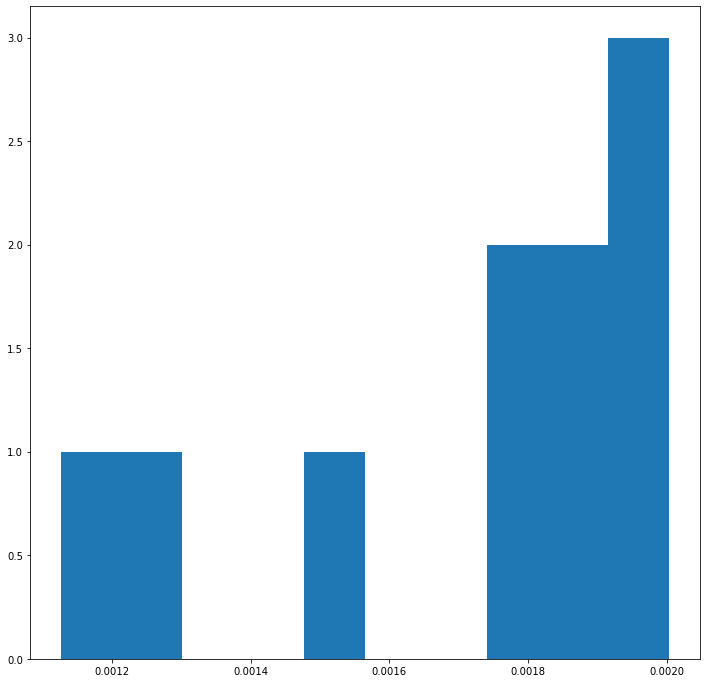

In [25]:
plt.hist(distances_2d)
# plt.xlim(0., 0.010)